In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn as nn

import hemul
hemul.USE_FPGA=False
from hemul import heaan
from muxcnn.resnet_HEAAN import ResNetHEAAN
from muxcnn.utils import get_channel_last

from muxcnn.models.ResNet20 import ResNet, BasicBlock
from muxcnn.utils import load_params, load_img, decrypt_result
from muxcnn.models.lightning import LitModel

Using CPU version HEAAN
Using CPU version HEAAN
Using CPU version HEAAN
Using CPU version HEAAN
Using CPU version HEAAN
Using CPU version HEAAN


/home/hoseung/anaconda3/envs/fhe/lib/python3.10/site-packages/lightning_utilities/core/imports.py:132: Unbuilt egg for bbsQt [unknown version] (/home/hoseung/Work/FHE/Kinect_BBS_demo)
/home/hoseung/anaconda3/envs/fhe/lib/python3.10/site-packages/lightning_utilities/core/imports.py:132: Unbuilt egg for bbsQt [unknown version] (/home/hoseung/Work/FHE/Kinect_BBS_demo)


# 1. 원본 Pytorch 모델

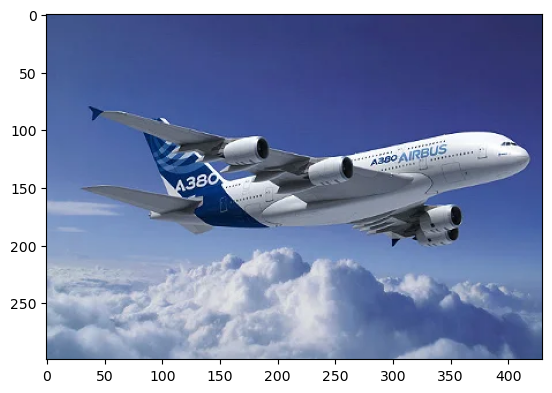

In [11]:
# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Lightning = True

resnet = ResNet(BasicBlock,[1,1,1])
resnet.eval() 

if Lightning:
    criterion = nn.CrossEntropyLoss()
    model = LitModel.load_from_checkpoint("./smooth79.pt", model=resnet, criterion=criterion)
    model_dict = model.model
else:
    # Load trained parameters
    load_params(resnet, fn_param="./ResNet8.pt", device='cpu')
    model_dict = resnet

# Load image
img_tensor = load_img("./Airplane.webp", hi=32, wi=32, show=True)

## FHE Setup

In [3]:
logp = 40
logq = 800
logn = 15

# Rotation 미리 준비 
rot_l = [2**i for i in range(15)]
rot_l = rot_l + [2**15-1, 
                 2**15-33, 2**15-32, 2**15-31,
                 2**15-17, 2**15-16, 2**15-15, 
                 2**15-9,2**15-8, 2**15-7] + [3,5,7,9,15,17, 31, 33]

hec = heaan.HEAANContext(logn, logp, logq, load_keys=True, rot_l=rot_l)
fhemodel = ResNetHEAAN(model_dict, hec)

Initializing the scheme as the data owner
Loading a secret key from:  ./SecretKey.txt
loading secret key done.
loaded ENC key from:  ./EncKey.txt
loaded MUL key from:  ./MulKey.txt
loaded ROT key from:  ./RotKey_1.txt
loaded ROT key from:  ./RotKey_2.txt
loaded ROT key from:  ./RotKey_4.txt
loaded ROT key from:  ./RotKey_8.txt
loaded ROT key from:  ./RotKey_16.txt
loaded ROT key from:  ./RotKey_32.txt
loaded ROT key from:  ./RotKey_64.txt
loaded ROT key from:  ./RotKey_128.txt
loaded ROT key from:  ./RotKey_256.txt
loaded ROT key from:  ./RotKey_512.txt
loaded ROT key from:  ./RotKey_1024.txt
loaded ROT key from:  ./RotKey_2048.txt
loaded ROT key from:  ./RotKey_4096.txt
loaded ROT key from:  ./RotKey_8192.txt
loaded ROT key from:  ./RotKey_16384.txt
loaded ROT key from:  ./RotKey_32767.txt
loaded ROT key from:  ./RotKey_32735.txt
loaded ROT key from:  ./RotKey_32736.txt
loaded ROT key from:  ./RotKey_32737.txt
loaded ROT key from:  ./RotKey_32751.txt
loaded ROT key from:  ./RotKey_327

### Pack and Encrypt the tensor image

In [12]:
ctxt = fhemodel.pack_img_ctxt(img_tensor)
#
# Normalize 안 해서 그런걸 수도 있음. 충분히!
#
# transforms.Normalize((0.5,), (0.5,))

# 2. Cehck Ciphertext 

### 2.1. save Ciphertext to file

In [5]:
heaan.he.SerializationUtils.writeCiphertext(ctxt, "packed_img.dat")

### 2.2 Load using Python 

In [6]:
import struct

f = open("packed_img.dat", "rb")
encrypted_img = f.read()

data = struct.iter_unpack('l', encrypted_img[:8*3]) # Ctxt header
read_nslots, read_logp, read_logq = data

print("Ciphertext has the following FHE parameters:")
print("nslots, logp, logq  = ", read_nslots, read_logp, read_logq)

Ciphertext has the following FHE parameters:
nslots, logp, logq  =  (32768,) (40,) (800,)


### 2.3. Try to interpret encrypted data

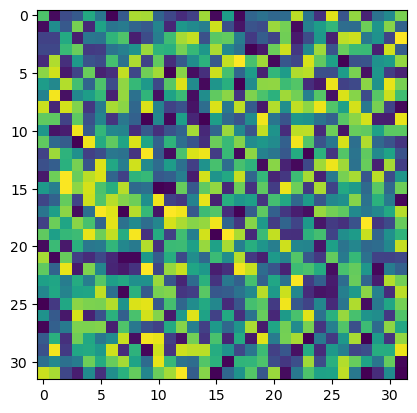

In [7]:
arr = np.frombuffer(encrypted_img[8*3:], dtype=np.int64)
reshaped = arr.reshape(32,32,-1)
plt.imshow(reshaped[:,:,0])

# 3. FHE model inference

In [13]:
result = fhemodel(ctxt)

class_num = decrypt_result(hec, result, verbose=True)
print("[FHE_CNN] Inference result:", class_num)
print(f"[FHE_CNN] It's a {classes[class_num]}")

[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[FHE_CNN_EARLY] ConvBN finished in 8.71 sec
[FHE_CNN_EARLY] ReLU started...
bootstrap done
[FHE_CNN_EARLY] ReLU hinished in 16.49 sec
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN1 finished in 15.12 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 17.00 sec
[FHE_CNN BasicBlock] ConvBN2 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN2 finished in 17.59 sec
[FHE_CNN BasicBlock] ReLU2 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU2 finished in 16.83 sec
[FHE_CNN] First Basic Block finished in 66.55 sec

[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[F

### 3.1 Comparison with Pytorch result

In [10]:
import torch
torch_result = model(img_tensor)
torch_class = torch.argmax(torch_result)
print(f"[PyTorch] It's a {classes[torch_class]}")

before softmax tensor([[ -9.4058, -10.6085,   0.3437,  -1.2886,  -6.4751,   4.5704,  -6.5122,
          -1.4584, -10.0124, -11.3946]], grad_fn=<AddmmBackward0>)
[PyTorch] It's a dog
